In [6]:
import os
import sys
from time import time
import numpy as np
sys.path.append('../')
from train import get_helper, get_batch_seq_len
import tensorflow as tf
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(font_scale=1.9)  # Make sure everything is readable.
sns.set_style("whitegrid")
figsize=(6,4)

# coco LM score

In [2]:
save_dir = '../save'
f_tmpl = os.path.join(save_dir, "{}_{}/{}_{}_epoch[{}]_pr[{}_{}]_temp[{}].txt")
TEMPERATURES = [0.8, 0.9, 0.95, 1.0, 1.01, 1.02, 1.03, 1.04, 1.06, 1.07, 1.08, 1.09, 2.25, 2.5, 2.75, 3.25, 3.5, 3.75]
PR_RATES = [0.0, 0.25, 0.5, 0.75]
models = ['tokmangan', 'maskgan']
modes = [('GAN', 200), ('MLE', 80)]
db = 'coco'
eval_dir = '{}_eval'.format(db)
eval_dir = os.path.join(save_dir, eval_dir)
if not os.path.exists(eval_dir):
    os.mkdir(eval_dir)

In [5]:
tf.reset_default_graph()
helper =  get_helper('coco', 'lm')
h_dim = 32
helper.emb_dim = h_dim
helper.hidden_dim = h_dim

helper.is_training = False
helper.init()
helper.build()
epoch = helper.load(helper.log_dir_MLE)

def get_lm_score(helper):
    scores = []
    for _ in range(helper.gen_data_loader.num_batch):
        batch = helper.gen_data_loader.next_batch()
        batch_len = get_batch_seq_len(batch)
        nlls = helper.sess.run(helper.generator.masked_nlls, feed_dict={
            helper.generator.x: batch,
            helper.generator.x_len: batch_len
        })
        scores.append(np.mean(nlls))
    return np.mean(scores)

(64, ?, 4616)
	Checkpoint found: /Users/minkyounggu/workspace/workDir/tokmangan/save/coco_lm/MLE/model.ckpt-80
	INFO:tensorflow:Restoring parameters from /Users/minkyounggu/workspace/workDir/tokmangan/save/coco_lm/MLE/model.ckpt-80


In [46]:
for model in models:
    for mode in modes:
        _mode = mode[0]
        _epoch = mode[1]
        LM = np.zeros((len(PR_RATES), len(TEMPERATURES)))
        prev = time()
        for i, pr_rate in enumerate(PR_RATES):
            for j, temp in enumerate(TEMPERATURES):
                fpath = f_tmpl.format(db, model, db, _mode, _epoch, pr_rate, pr_rate, temp)
                helper.load_data(fpath, helper.gen_data_loader)
                lm_score = get_lm_score(helper)
                LM[i, j] = lm_score
        elapsed = (time() - prev)/60
        print("elapsed:{}m".format(int(elapsed)), model, _mode)
        np.savetxt(os.path.join(eval_dir, "{}_{}_LM.csv".format(model, _mode)), LM, delimiter=",")

elapsed:9m tokmangan GAN
elapsed:8m tokmangan MLE
elapsed:8m maskgan GAN
elapsed:8m maskgan MLE


In [56]:
maskgan_lm = np.genfromtxt('save/coco_eval/maskgan_GAN_LM.csv', delimiter=',')
maskmle_lm = np.genfromtxt('save/coco_eval/maskgan_MLE_LM.csv', delimiter=',')
tokmangan_lm = np.genfromtxt('save/coco_eval/tokmangan_GAN_LM.csv', delimiter=',')
tokmanmle_lm = np.genfromtxt('save/coco_eval/tokmangan_MLE_LM.csv', delimiter=',')

# coco RLM score

In [31]:
from train import get_helper, get_batch_seq_len
import tensorflow as tf
import os

save_dir = '../save'
f_tmpl = os.path.join(save_dir, "{}_{}/{}_{}_epoch[{}]_pr[{}_{}]_temp[{}].txt")
TEMPERATURES = [0.8, 0.9, 0.95, 1.0, 1.01, 1.02, 1.03, 1.04, 1.06, 1.07, 1.08, 1.09, 2.25, 2.5, 2.75, 3.25, 3.5, 3.75]
TEMPERATURES = TEMPERATURES[::2]
PR_RATES = [0.0]
models = {
   'tokmangan': [('GAN', 200)],
    'maskgan': [('MLE', 80)]
}
db = 'coco'
eval_dir = '{}_eval'.format(db)
eval_dir = os.path.join(save_dir, eval_dir)
if not os.path.exists(eval_dir):
    os.mkdir(eval_dir)

In [32]:
def _get_rlm_score(model_name, fpath):
    tf.reset_default_graph()
    helper = get_helper(db, model_name, rlm=True, rlm_data_loc=fpath)
    helper.is_training = True
    
    helper.emb_dim = 32
    helper.hidden_dim = 32
    helper.print_every = 40

    helper.pre_epoch_num = 80
    score =  helper.train(pretrain_gen=True, pretrain_dis=False, train_gan=False)    
    return score

In [33]:
for model, modes in models.items():
    for mode in modes:
        _mode = mode[0]
        _epoch = mode[1]
        RLM = np.zeros((len(PR_RATES), len(TEMPERATURES)))
        prev = time()
        for i, pr_rate in enumerate(PR_RATES):
            for j, temp in enumerate(TEMPERATURES):
                fpath = f_tmpl.format(db, model, db, _mode, _epoch, pr_rate, pr_rate, temp)
                model_name = "lm_{}_{}_PR[{}]_TEMP:[{}]".format(model, _mode, pr_rate, temp)
                print(model_name)
                RLM[i, j] = _get_rlm_score(model_name, fpath)
        elapsed = (time() - prev)/60
        print("elapsed:{}m".format(int(elapsed)), model, _mode)
        np.savetxt(os.path.join(eval_dir, "{}_{}_RLM.csv".format(model, _mode)), RLM, delimiter=",")

lm_maskgan_MLE_PR[0.0]_TEMP:[0.8]
(64, ?, 4616)
start pre-train generator:
No checkpoint found
epoch:40 	 elapsed:72s 	 loss:2.478
	time:7s 	best_rlm:4.512 	current_rlm:4.512
epoch:80 	 elapsed:74s 	 loss:2.234
	time:7s 	best_rlm:4.502 	current_rlm:4.614
lm_maskgan_MLE_PR[0.0]_TEMP:[0.95]
(64, ?, 4616)
start pre-train generator:
No checkpoint found
epoch:40 	 elapsed:74s 	 loss:1.991
	time:7s 	best_rlm:4.458 	current_rlm:4.458
epoch:80 	 elapsed:67s 	 loss:1.796
	time:6s 	best_rlm:4.445 	current_rlm:4.534
lm_maskgan_MLE_PR[0.0]_TEMP:[1.01]
(64, ?, 4616)
start pre-train generator:
No checkpoint found
epoch:40 	 elapsed:67s 	 loss:1.868
	time:6s 	best_rlm:4.531 	current_rlm:4.531
epoch:80 	 elapsed:68s 	 loss:1.654
	time:6s 	best_rlm:4.516 	current_rlm:4.625
lm_maskgan_MLE_PR[0.0]_TEMP:[1.03]
(64, ?, 4616)
start pre-train generator:
No checkpoint found
epoch:40 	 elapsed:63s 	 loss:1.937
	time:6s 	best_rlm:4.566 	current_rlm:4.566
epoch:80 	 elapsed:64s 	 loss:1.688
	time:6s 	best_rlm:4.

In [35]:
maskmle_lm = np.genfromtxt('save/coco_eval/maskgan_MLE_LM.csv', delimiter=',')[0, ::2]
tokmangan_lm = np.genfromtxt('save/coco_eval/tokmangan_GAN_LM.csv', delimiter=',')[0, ::2]
maskmle_rlm = np.genfromtxt('save/coco_eval/maskgan_MLE_RLM.csv', delimiter=',')
tokmangan_rlm = np.genfromtxt('save/coco_eval/tokmangan_GAN_RLM.csv', delimiter=',')

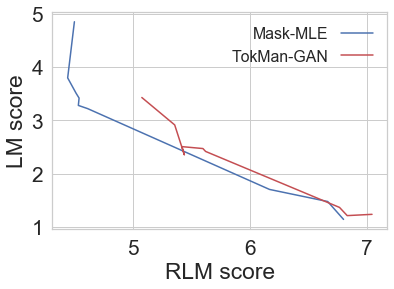

In [45]:
size=15
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

# plt.title('Mask Rate: {}'.format(1-PR_RATES[idx]))
ax.plot(maskmle_rlm,  maskmle_lm, 'b', alpha=1.0, label='Mask-MLE')
ax.plot(tokmangan_rlm, tokmangan_lm, 'r', alpha=1.0, label='TokMan-GAN')

ax.set_xlabel('RLM score')
ax.set_ylabel('LM score')

# plt.axis([-0.42, -0.13, 0.1, 0.4])
plt.legend(markerfirst=False, frameon=False, fontsize='x-small')
plt.show()